## **Import Library**

1. pandas: Manipulasi data dalam bentuk DataFrame.
2. numpy: Operasi matematika/array.
3. matplotlib.pyplot & seaborn: Visualisasi data.
4. re, string: Untuk pembersihan teks (regex, manipulasi string).
5. nltk: Natural Language Toolkit untuk preprocessing teks (tokenisasi, stopword removal, dll).
nltk.download('punkt'): Tokenisasi teks menjadi kata.
nltk.download('stopwords'): Mendapatkan daftar kata umum yang akan dihapus.
6. Sastrawi: Mengubah kata menjadi bentuk dasar (stemming).
7. Metrik Evaluasi
  * accuracy_score: Persentase prediksi benar
  * precision_score: Akurasi pada prediksi positif
  * recall_score: Kemampuan model mendeteksi kelas sebenarnya.
  * f1_score: Rata-rata harmonis dari Precision dan Recall.
  * classification_report: Laporan metrik evaluasi untuk setiap kelas.
  * roc_auc_score: Menilai kemampuan model pada multi-class classification berdasarkan probabilitas.




In [1]:
!pip install nltk
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

#for modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## **Load Data**

Langkah selanjutnya gunakan pandas untuk membaca dataset dari file CSV dan menampilkan jumlah baris serta kolom dalam dataset tersebut.

In [3]:
#Load Data
data=pd.read_csv('dataset_sms_spam_v1.csv')
print(data.shape)

(1143, 2)


In [4]:
data.head(10)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket ...,2
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan ...",2
7,Akhir bulan harus tetap eksis loh! Internetan ...,2
8,Aktifkan iRing Coboy Jr - Terhebat. Tekan *808...,2
9,Ambil bonus harianmu di *600# (Bebas Pulsa). D...,2


# **Text Cleaning**

Memeriksa jumlah nilai yang hilang (missing values) dalam setiap kolom pada dataset.

In [5]:
#Missing values
data.isna().sum()

,0
Teks,0
label,0


In [6]:
# Mengecek duplikat
duplikat = data[data.duplicated()]
print(duplikat)
print(f"Jumlah duplikat: {duplikat.shape[0]}")

                                                  Teks  label
679  bebas nama1, terus nanti kalau ada tgl libur, ...      0
Jumlah duplikat: 1


In [7]:
data = data.drop_duplicates()

In [8]:
# Mengecek duplikat
duplikat = data[data.duplicated()]
print(f"Jumlah duplikat: {duplikat.shape[0]}")

Jumlah duplikat: 0


In [9]:
print(data.shape)

(1142, 2)


**Visualisasi data**
Distribusi kelas (label) divisualisasikan menggunakan Seaborn & matplotlib.
Warna ditentukan untuk membedakan kategori: hijau (normal), merah (fraud), biru (promo).

In [10]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=data['label'].value_counts()
x

,count
label,
0,568
1,335
2,239


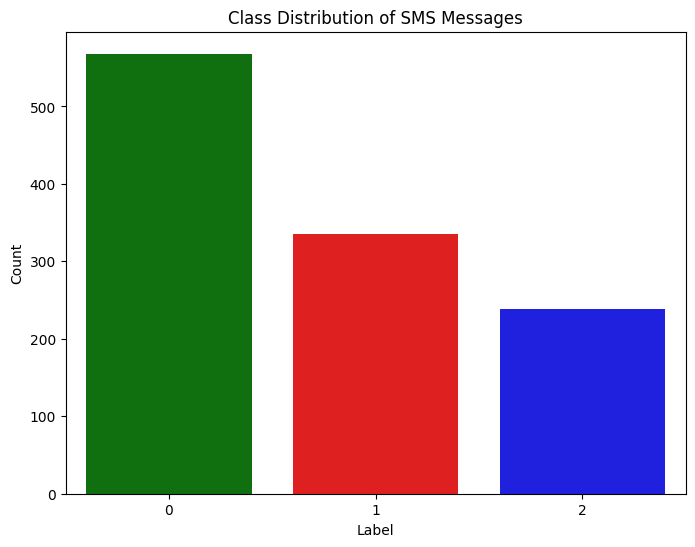

In [11]:
custom_palette = {0: 'green', 1: 'red', 2: 'blue'}

plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='label', data=data, palette=custom_palette, legend=False)
plt.title('Class Distribution of SMS Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [12]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE) #remove https
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    text = re.sub(r'\b\w{1,2}\b', '', text) # Remove single characters
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text)) # Remove single letters standing alone

    return text

data['clean_text'] = data['Teks'].apply(clean_text)
display(data[['Teks', 'clean_text']].style)

,Teks,clean_text
0,"[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek di tsel.me/mytsel1 S&K",promo beli paket flash mulai telkomsel app dpt extra kuota lte dan extra nelpon hingga mnthr buruan cek tselmemytsel
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat Anda yang terpilih. Aktifkan sekarang juga di *550*905#. Promo sd 30 Nov 2015.Buruan aktifkan sekarang. S&K,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga promo nov buruan aktifkan sekarang
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#",plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash Anda 7160KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#",plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat anda yang terpilih. Aktifkan sekarang juga di *550*907# Buruan..! SKB,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga buruan skb
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1,hari lagi ekstra pulsa beli paket internet bulanan mytelkomsel utk pembelian pertama sjk augsept cek detail promo tselmemytsel
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan Rp. 3190/7hr) dari hits Armada - Pencuri Hati. Tekan *808*3*1*4*1# lalu OK/Call. Info: 100&111",ada iring dgn tarif perpanjangan dari hits armada pencuri hati tekan lalu okcall info
7,Akhir bulan harus tetap eksis loh! Internetan pake volume ultima 900MB/30hr. Hrga mulai Rp 35rb di *100*471#. Tarif&lokasi cek di tsel.me/fl,akhir bulan harus tetap eksis loh internetan pake volume ultima mbhr hrga mulai tariflokasi cek tselmefl
8,"Aktifkan iRing Coboy Jr - Terhebat. Tekan *808*7#. Info: 100&111 Ada hits terbaru dari NOAH - Jika Engkau. Aktifkan iRing nya di HP kamu. Ketik MG NOAH02 kirim ke 808 Info: 100&111 Berkah iRing Rp 1000 dr Yuni Shara - Akhirnya. Aktifkan iRing nya, Tkn *808*1*2*3# lalu Ok/Call. Raih THR PuluhanJt!. Berhenti: Unreg ke 808",aktifkan iring coboy terhebat tekan info ada hits terbaru dari noah jika engkau aktifkan iring nya kamu ketik noah kirim info berkah iring yuni shara akhirnya aktifkan iring nya tkn lalu okcall raih thr puluhanjt berhenti unreg
9,Ambil bonus harianmu di *600# (Bebas Pulsa). Dptkan gratis nelpon atau internetan dan promo lainnya sesuai hobimu!,ambil bonus harianmu bebas pulsa dptkan gratis nelpon atau internetan dan promo lainnya sesuai hobimu


# **Preprocessing**

In [13]:
def tokenize_text(text):
    # Menggunakan word_tokenize untuk memecah teks menjadi token (kata)
    tokens = word_tokenize(text)
    return tokens

# Menerapkan fungsi tokenize_text pada kolom 'clean_text' dan menyimpan hasilnya di kolom baru 'Tokenized_Text'
data['Tokenized_Text'] = data['clean_text'].apply(tokenize_text)

# Menampilkan kolom 'clean_text' dan 'Tokenized_Text' dalam format tabel yang lebih baik
display(data[['clean_text', 'Tokenized_Text']].style)

,clean_text,Tokenized_Text
0,promo beli paket flash mulai telkomsel app dpt extra kuota lte dan extra nelpon hingga mnthr buruan cek tselmemytsel,"['promo', 'beli', 'paket', 'flash', 'mulai', 'telkomsel', 'app', 'dpt', 'extra', 'kuota', 'lte', 'dan', 'extra', 'nelpon', 'hingga', 'mnthr', 'buruan', 'cek', 'tselmemytsel']"
1,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga promo nov buruan aktifkan sekarang,"['hari', 'hanya', 'ribu', 'spesial', 'buat', 'anda', 'yang', 'terpilih', 'aktifkan', 'sekarang', 'juga', 'promo', 'nov', 'buruan', 'aktifkan', 'sekarang']"
2,plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub,"['plg', 'yth', 'sisa', 'kuota', 'flash', 'anda', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'utk', 'cek', 'kuotabeli', 'paket', 'flash', 'atau', 'hub']"
3,plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub,"['plg', 'yth', 'sisa', 'kuota', 'flash', 'anda', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'utk', 'cek', 'kuotabeli', 'paket', 'flash', 'atau', 'hub']"
4,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga buruan skb,"['hari', 'hanya', 'ribu', 'spesial', 'buat', 'anda', 'yang', 'terpilih', 'aktifkan', 'sekarang', 'juga', 'buruan', 'skb']"
5,hari lagi ekstra pulsa beli paket internet bulanan mytelkomsel utk pembelian pertama sjk augsept cek detail promo tselmemytsel,"['hari', 'lagi', 'ekstra', 'pulsa', 'beli', 'paket', 'internet', 'bulanan', 'mytelkomsel', 'utk', 'pembelian', 'pertama', 'sjk', 'augsept', 'cek', 'detail', 'promo', 'tselmemytsel']"
6,ada iring dgn tarif perpanjangan dari hits armada pencuri hati tekan lalu okcall info,"['ada', 'iring', 'dgn', 'tarif', 'perpanjangan', 'dari', 'hits', 'armada', 'pencuri', 'hati', 'tekan', 'lalu', 'okcall', 'info']"
7,akhir bulan harus tetap eksis loh internetan pake volume ultima mbhr hrga mulai tariflokasi cek tselmefl,"['akhir', 'bulan', 'harus', 'tetap', 'eksis', 'loh', 'internetan', 'pake', 'volume', 'ultima', 'mbhr', 'hrga', 'mulai', 'tariflokasi', 'cek', 'tselmefl']"
8,aktifkan iring coboy terhebat tekan info ada hits terbaru dari noah jika engkau aktifkan iring nya kamu ketik noah kirim info berkah iring yuni shara akhirnya aktifkan iring nya tkn lalu okcall raih thr puluhanjt berhenti unreg,"['aktifkan', 'iring', 'coboy', 'terhebat', 'tekan', 'info', 'ada', 'hits', 'terbaru', 'dari', 'noah', 'jika', 'engkau', 'aktifkan', 'iring', 'nya', 'kamu', 'ketik', 'noah', 'kirim', 'info', 'berkah', 'iring', 'yuni', 'shara', 'akhirnya', 'aktifkan', 'iring', 'nya', 'tkn', 'lalu', 'okcall', 'raih', 'thr', 'puluhanjt', 'berhenti', 'unreg']"
9,ambil bonus harianmu bebas pulsa dptkan gratis nelpon atau internetan dan promo lainnya sesuai hobimu,"['ambil', 'bonus', 'harianmu', 'bebas', 'pulsa', 'dptkan', 'gratis', 'nelpon', 'atau', 'internetan', 'dan', 'promo', 'lainnya', 'sesuai', 'hobimu']"


In [14]:
# Membaca file CSV yang berisi kata-kata yang dinormalisasi
normalizad_word = pd.read_csv("normalisasi.csv")
normalizad_word_dict = {}
for index, row in normalizad_word.iterrows():
    # Menggunakan .iloc[] untuk pengindeksan posisi
    if row.iloc[0] not in normalizad_word_dict:
        normalizad_word_dict[row.iloc[0]] = row.iloc[1]

# Mendefinisikan fungsi untuk menormalkan istilah dalam dokumen
def normalized_term(document):
    # Mengganti setiap istilah dalam dokumen dengan istilah yang dinormalisasi jika ada dalam dictionary
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

# Menerapkan fungsi normalized_term pada kolom 'Tokenized_Text' untuk menormalkan kata-kata
data['Tokenized_Text'] = data['Tokenized_Text'].apply(normalized_term)

# Menampilkan kolom 'Teks' dan 'Tokenized_Text' dalam format tabel yang lebih baik
display(data[['Teks', 'Tokenized_Text']].style)

,Teks,Tokenized_Text
0,"[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek di tsel.me/mytsel1 S&K","['promo', 'beli', 'paket', 'flash', 'mulai', 'telkomsel', 'app', 'dapat', 'extra', 'kuota', 'lte', 'dan', 'extra', 'nelpon', 'hingga', 'mnthr', 'buruan', 'cek', 'tselmemytsel']"
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat Anda yang terpilih. Aktifkan sekarang juga di *550*905#. Promo sd 30 Nov 2015.Buruan aktifkan sekarang. S&K,"['hari', 'hanya', 'ribu', 'spesial', 'buat', 'anda', 'yang', 'terpilih', 'aktifkan', 'sekarang', 'juga', 'promo', 'nov', 'buruan', 'aktifkan', 'sekarang']"
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#","[' pelanggan', 'yang terhormat', 'sisa', 'kuota', 'flash', 'anda', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'untuk', 'cek', 'kuotabeli', 'paket', 'flash', 'atau', 'hub']"
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash Anda 7160KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#","[' pelanggan', 'yang terhormat', 'sisa', 'kuota', 'flash', 'anda', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'untuk', 'cek', 'kuotabeli', 'paket', 'flash', 'atau', 'hub']"
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat anda yang terpilih. Aktifkan sekarang juga di *550*907# Buruan..! SKB,"['hari', 'hanya', 'ribu', 'spesial', 'buat', 'anda', 'yang', 'terpilih', 'aktifkan', 'sekarang', 'juga', 'buruan', 'skb']"
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1,"['hari', 'lagi', 'ekstra', 'pulsa', 'beli', 'paket', 'internet', 'bulanan', 'mytelkomsel', 'untuk', 'pembelian', 'pertama', 'sjk', 'augsept', 'cek', 'detail', 'promo', 'tselmemytsel']"
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan Rp. 3190/7hr) dari hits Armada - Pencuri Hati. Tekan *808*3*1*4*1# lalu OK/Call. Info: 100&111","['ada', 'iring', 'dgn', 'tarif', 'perpanjangan', 'dari', 'hits', 'armada', 'pencuri', 'hati', 'tekan', 'lalu', 'okcall', 'info']"
7,Akhir bulan harus tetap eksis loh! Internetan pake volume ultima 900MB/30hr. Hrga mulai Rp 35rb di *100*471#. Tarif&lokasi cek di tsel.me/fl,"['akhir', 'bulan', 'harus', 'tetap', 'eksis', 'loh', 'internetan', 'pakai', 'volume', 'ultima', 'mbhr', 'harga', 'mulai', 'tariflokasi', 'cek', 'tselmefl']"
8,"Aktifkan iRing Coboy Jr - Terhebat. Tekan *808*7#. Info: 100&111 Ada hits terbaru dari NOAH - Jika Engkau. Aktifkan iRing nya di HP kamu. Ketik MG NOAH02 kirim ke 808 Info: 100&111 Berkah iRing Rp 1000 dr Yuni Shara - Akhirnya. Aktifkan iRing nya, Tkn *808*1*2*3# lalu Ok/Call. Raih THR PuluhanJt!. Berhenti: Unreg ke 808","['aktifkan', 'iring', 'coboy', 'terhebat', 'tekan', 'info', 'ada', 'hits', 'terbaru', 'dari', 'noah', 'jika', 'engkau', 'aktifkan', 'iring', 'nya', 'kamu', 'ketik', 'noah', 'kirim', 'info', 'berkah', 'iring', 'yuni', 'shara', 'akhirnya', 'aktifkan', 'iring', 'nya', 'tkn', 'lalu', 'okcall', 'raih', 'thr', 'puluhanjt', 'berhenti', 'unreg']"
9,Ambil bonus harianmu di *600# (Bebas Pulsa). Dptkan gratis nelpon atau internetan dan promo lainnya sesuai hobimu!,"['ambil', 'bonus', 'harianmu', 'bebas', 'pulsa', 'dapatkan', 'gratis', 'nelpon', 'atau', 'internetan', 'dan', 'promo', 'lainnya', 'sesuai', 'hobimu']"


In [15]:
data['Normalized_Text'] = data['Tokenized_Text'].apply(' '.join)
display(data[['Teks', 'Normalized_Text']])

,Teks,Normalized_Text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo beli paket flash mulai telkomsel app dap...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,hari hanya ribu spesial buat anda yang terpili...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",pelanggan yang terhormat sisa kuota flash and...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",pelanggan yang terhormat sisa kuota flash and...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,hari hanya ribu spesial buat anda yang terpili...
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",yooo sama oke nanti saya umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,sebelumnya menulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,mba mau kirim
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,nama beaok bwrangkat pagimau cas atay tranfer


In [16]:
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

data['Filtered_Tokens'] = data['Tokenized_Text'].apply(remove_stopwords)
# Menampilkan DataFrame dengan kolom 'Cleaned_Text' dan 'Filtered_Tokens'
display(data[['clean_text', 'Filtered_Tokens']].style)

,clean_text,Filtered_Tokens
0,promo beli paket flash mulai telkomsel app dpt extra kuota lte dan extra nelpon hingga mnthr buruan cek tselmemytsel,"['promo', 'beli', 'paket', 'flash', 'telkomsel', 'app', 'extra', 'kuota', 'lte', 'extra', 'nelpon', 'mnthr', 'buruan', 'cek', 'tselmemytsel']"
1,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga promo nov buruan aktifkan sekarang,"['ribu', 'spesial', 'terpilih', 'aktifkan', 'promo', 'nov', 'buruan', 'aktifkan']"
2,plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub,"[' pelanggan', 'yang terhormat', 'sisa', 'kuota', 'flash', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'cek', 'kuotabeli', 'paket', 'flash', 'hub']"
3,plg yth sisa kuota flash anda download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash atau hub,"[' pelanggan', 'yang terhormat', 'sisa', 'kuota', 'flash', 'download', 'mytelkomsel', 'apps', 'httptselmetsel', 'cek', 'kuotabeli', 'paket', 'flash', 'hub']"
4,hari hanya ribu spesial buat anda yang terpilih aktifkan sekarang juga buruan skb,"['ribu', 'spesial', 'terpilih', 'aktifkan', 'buruan', 'skb']"
5,hari lagi ekstra pulsa beli paket internet bulanan mytelkomsel utk pembelian pertama sjk augsept cek detail promo tselmemytsel,"['ekstra', 'pulsa', 'beli', 'paket', 'internet', 'bulanan', 'mytelkomsel', 'pembelian', 'sjk', 'augsept', 'cek', 'detail', 'promo', 'tselmemytsel']"
6,ada iring dgn tarif perpanjangan dari hits armada pencuri hati tekan lalu okcall info,"['iring', 'dgn', 'tarif', 'perpanjangan', 'hits', 'armada', 'pencuri', 'hati', 'tekan', 'okcall', 'info']"
7,akhir bulan harus tetap eksis loh internetan pake volume ultima mbhr hrga mulai tariflokasi cek tselmefl,"['eksis', 'loh', 'internetan', 'pakai', 'volume', 'ultima', 'mbhr', 'harga', 'tariflokasi', 'cek', 'tselmefl']"
8,aktifkan iring coboy terhebat tekan info ada hits terbaru dari noah jika engkau aktifkan iring nya kamu ketik noah kirim info berkah iring yuni shara akhirnya aktifkan iring nya tkn lalu okcall raih thr puluhanjt berhenti unreg,"['aktifkan', 'iring', 'coboy', 'terhebat', 'tekan', 'info', 'hits', 'terbaru', 'noah', 'engkau', 'aktifkan', 'iring', 'nya', 'ketik', 'noah', 'kirim', 'info', 'berkah', 'iring', 'yuni', 'shara', 'aktifkan', 'iring', 'nya', 'tkn', 'okcall', 'raih', 'thr', 'puluhanjt', 'berhenti', 'unreg']"
9,ambil bonus harianmu bebas pulsa dptkan gratis nelpon atau internetan dan promo lainnya sesuai hobimu,"['ambil', 'bonus', 'harianmu', 'bebas', 'pulsa', 'dapatkan', 'gratis', 'nelpon', 'internetan', 'promo', 'sesuai', 'hobimu']"


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

data['Stemmed_Tokens'] = data['Filtered_Tokens'].apply(stem_tokens)

In [ ]:
display(data[['clean_text', 'Stemmed_Tokens']].style)

In [ ]:
data['Cleaned_Text'] = data['Stemmed_Tokens'].apply(' '.join)
display(data[['Teks', 'Cleaned_Text']])

In [ ]:
display(data[['Teks', 'Cleaned_Text', 'Normalized_Text']])

## **Modelling**

Membangun model klasifikasi berbasis Support Vector Machine (SVM) dengan kernel linear untuk mengklasifikasikan pesan SMS menjadi tiga kategori: Normal, Penipuan, atau Promo. Dataset diolah menggunakan teknik TF-IDF untuk representasi teks numerik, dan performa model dievaluasi menggunakan metrik seperti akurasi, presisi, recall, F1-score, serta AUC.

In [ ]:
X = data['Cleaned_Text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = SVC(kernel='linear', probability=True)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
y_prob = model.predict_proba(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print('AUC:', roc_auc)